# La nuit

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

influxDB:  http://127.0.0.1:8083/  
Grafana: http://127.0.0.1:3000/dashboard/db/weatherdata?orgId=1

In [2]:
from influxdb import DataFrameClient

In [3]:
# see https://influxdb-python.readthedocs.io/en/latest/examples.html#tutorials-pandas
"""Instantiate the connection to the InfluxDB client."""

host, port = 'localhost', 8086
user, password = 'root', 'root'
dbname = 'weatherdata'
protocol = 'json' # 'line'

CLIENT = DataFrameClient(host, port, user, password, dbname)

print("Create database: " + dbname)
CLIENT.create_database(dbname)

Create database: weatherdata


In [4]:
d1 = '2017-07-12'

In [5]:
d2_dt = pd.to_datetime( d1 ) + pd.to_timedelta('1d')
d2 = d2_dt.strftime( '%Y-%m-%d' )
print( d2 )

2017-07-13


In [6]:
query = "SELECT T_int FROM openenergymonitor WHERE  time >= '%s 22:00:00' and time <= '%s 06:00:00'"%(d1, d2)
T_int_data = CLIENT.query(query)

In [7]:
query =  "SELECT temperature FROM darksky WHERE  time >= '%s 22:00:00' and time <= '%s 06:00:00'"%(d1, d2)
T_ext_data = CLIENT.query(query)

In [8]:
def toarray( DF ):
    data_dict = DF.to_dict(orient='list')
    time_sec = DF.index.astype(np.int64) // 1e9    # conversion en secondes
    
    time_sec = time_sec - time_sec[0]
    time_sec = time_sec / 3600
    data = [ k for k in data_dict.values() ][0]
    
    return time_sec, data

In [9]:
time_Tint, T_int = toarray( T_int_data['openenergymonitor'] )

In [10]:
d = T_ext_data['darksky'].index[0]

In [11]:
time_Text, T_ext = toarray( T_ext_data['darksky'] )

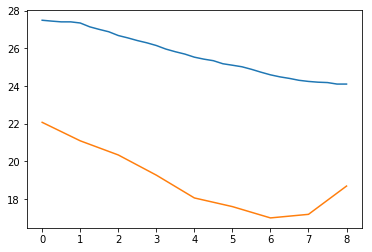

In [12]:
plt.plot( time_Tint, T_int )
plt.plot( time_Text, T_ext )

## Fit spline

In [13]:
from scipy.interpolate import UnivariateSpline

In [14]:
xnew = np.linspace( 0, time_Tint[-1], 200 )

In [15]:
spline = UnivariateSpline( time_Tint, T_int )

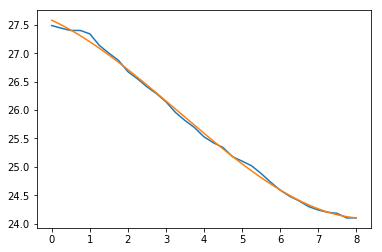

In [16]:
plt.plot( time_Tint, T_int )
plt.plot( xnew, spline( xnew ) )

In [17]:
spline.get_coeffs()

array([ 27.57977248,  26.75963421,  24.25383464,  24.10109336])

In [18]:
spline_dTdt = spline.derivative()

In [19]:
spline_dTdt( time_Text )

array([-0.30755185, -0.44191823, -0.52895585, -0.56866474, -0.56104488,
       -0.50609627, -0.40381892, -0.25421282, -0.05727798])

In [20]:
deltaT = T_ext - spline( time_Text )
dTdt = spline_dTdt( time_Text )

h_M = dTdt / deltaT

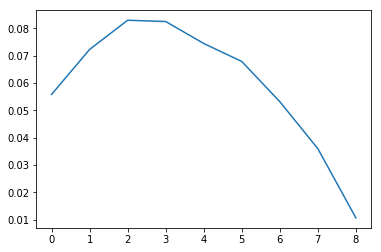

In [21]:
plt.plot( h_M )

In [57]:
def get_hM( d1 ):
    d2_dt = pd.to_datetime( d1 ) + pd.to_timedelta('1d')
    d2 = d2_dt.strftime( '%Y-%m-%d' )
    
    query = "SELECT T_int FROM openenergymonitor WHERE  time >= '%s 22:00:00' and time <= '%s 06:00:00'"%(d1, d2)
    T_int_data = CLIENT.query(query)
    
    query =  "SELECT temperature FROM darksky WHERE  time >= '%s 22:00:00' and time <= '%s 06:00:00'"%(d1, d2)
    T_ext_data = CLIENT.query(query)
    
    time_Tint, T_int = toarray( T_int_data['openenergymonitor'] )
    time_Text, T_ext = toarray( T_ext_data['darksky'] )
    
    spline = UnivariateSpline( time_Tint, T_int )#, s=1.05 )
    spline_dTdt = spline.derivative()
    
    deltaT = T_ext - spline( time_Text )
    dTdt = spline_dTdt( time_Text )

    h_M = dTdt / deltaT
    
    #T_ext_data['darksky'].tz_convert('Europe/Paris')
    time_index = T_ext_data['darksky'].index
    return time_index, h_M
    

In [58]:
get_hM( '2017-07-20' )

(DatetimeIndex(['2017-07-20 22:00:00+00:00', '2017-07-20 23:00:00+00:00',
                '2017-07-21 00:00:00+00:00', '2017-07-21 01:00:00+00:00',
                '2017-07-21 02:00:00+00:00', '2017-07-21 03:00:00+00:00',
                '2017-07-21 04:00:00+00:00', '2017-07-21 05:00:00+00:00',
                '2017-07-21 06:00:00+00:00'],
               dtype='datetime64[ns, UTC]', freq=None),
 array([ 0.01231304,  0.01169051,  0.01082727,  0.01032138,  0.00996909,
         0.00974905,  0.00958718,  0.01048958,  0.01248501]))

## iterate

In [59]:
firstday = '2017-07-02'
lastday = '2017-10-07'

daterange = pd.date_range(start=firstday, end=lastday,  freq='D', normalize=True)
daterange_iso = daterange.strftime('%Y-%m-%d')

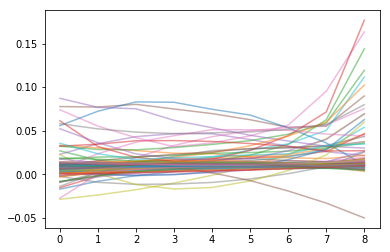

In [60]:
all_hM = []
for day in daterange_iso:
    time, h_M = get_hM( day )
    plt.plot( h_M, alpha=0.5 )
    all_hM.append( h_M )

In [61]:
all_hM = np.array( all_hM ).flatten()

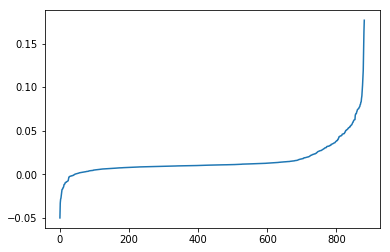

In [62]:
plt.plot( np.sort(all_hM) )

In [63]:
time, h_M = get_hM( day )
DF = pd.DataFrame( {'h_M':h_M}, index=time )

In [64]:
measurement_name = 'analyse'

for day in daterange_iso:
    time, h_M = get_hM( day )
    DF = pd.DataFrame( {'h_M':h_M}, index=time )
    
    # Ajoute colone par colones pour retirer les NaN...
    for c in DF.columns:
        CLIENT.write_points(DF[[c]].dropna(), measurement_name)

In [65]:
DF

,h_M
2017-10-07 22:00:00+00:00,0.012715
2017-10-07 23:00:00+00:00,0.013120
2017-10-08 00:00:00+00:00,0.012944
2017-10-08 01:00:00+00:00,0.012583
2017-10-08 02:00:00+00:00,0.012319
2017-10-08 03:00:00+00:00,0.011967
2017-10-08 04:00:00+00:00,0.010606
2017-10-08 05:00:00+00:00,0.009604
2017-10-08 06:00:00+00:00,0.007828
